In [112]:
# thêm thư viện
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import normaltest
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [113]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('Data/merged_data.csv')
data.head(5)

,Date,Price,Open,High,Low,Vol.,Change %,XSTC
0,2018-06-05,3592.5,3523.6,3631.8,3425.1,140590.0,4.89,AGR
1,2018-06-06,3612.1,3592.5,3631.8,3543.2,113340.0,0.55,AGR
2,2018-06-07,3641.7,3641.7,3651.5,3592.5,75800.0,0.82,AGR
3,2018-06-08,3562.9,3641.7,3641.7,3543.2,118030.0,-2.16,AGR
4,2018-06-11,3533.4,3562.9,3562.9,3444.8,82080.0,-0.83,AGR


In [114]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7450 entries, 0 to 7449
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      7450 non-null   datetime64[ns]
 1   Price     7450 non-null   float64       
 2   Open      7450 non-null   float64       
 3   High      7450 non-null   float64       
 4   Low       7450 non-null   float64       
 5   Vol.      7450 non-null   float64       
 6   Change %  7450 non-null   float64       
 7   XSTC      7450 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 465.8+ KB


In [115]:
# Group by the 'XSTC' column
grouped = data.groupby('XSTC')

# Create a dictionary to hold each group as a separate dataframe
dataframes = {name: group for name, group in grouped}

In [116]:
group_name_0 = list(dataframes.keys())[0]
group_name_0

'AGR'

In [117]:
AGR_df = dataframes[group_name_0]
print(AGR_df.head(2))
print(AGR_df.tail(2))

        Date   Price    Open    High     Low      Vol.  Change % XSTC
0 2018-06-05  3592.5  3523.6  3631.8  3425.1  140590.0      4.89  AGR
1 2018-06-06  3612.1  3592.5  3631.8  3543.2  113340.0      0.55  AGR
           Date    Price     Open     High      Low       Vol.  Change % XSTC
1488 2024-05-20  20150.0  20100.0  20600.0  20100.0  1410000.0      0.25  AGR
1489 2024-05-21  19850.0  20100.0  20100.0  19800.0   499800.0     -1.49  AGR


## **1. Kiểm tra Stationarity**

**Stationarity**
- **Strict stationarity**: the joint distribution of any set of observations in the series remains the same regardless of the time at which the observations are taken.

- **Weak stationarity**: The mean is constant over time; The variance is finite; The covariance of $X(t)$ and $X(t+h)$ depends only on $h$, i.e., is shift-invariance in time.

**Dưới đây, ta kiểm tra tính chất weak stationarity của các time series. Một time series đạt weak stationarity cần thỏa mãn 4 tính chất liệt kê sau đây:**
- Constant mean (no trend). #1
- Constant variance (no heteroskedasticity). #2
- Constant autocorrelation structure (depend on the lag $h$ only). #3

**Để kiểm tra stationarity trong time series chúng ta kết hợp nhiều cách khác nhau. Dưới đây sẽ sử dụng 4 kỹ thuật bao gồm:**
- Run-sequence plots: Trực quan để dự đoán xu hướng, chu kỳ,...
- Summary statistics: Chia time series thành các chunk nhỏ để kiểm tra mean và variance.
- Histogram plots
- Augmented Dickey-Fuller test

#### **1.1. Ngân hàng AGRIBANK**

**Run-sequence plot**

In [118]:
def subsquence_plot_price(df, df_name):
    plt.figure(figsize=(14, 3))
    plt.plot(df['Date'], df['Price'])
    plt.title(f'Stock Price Over Time for {df_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)

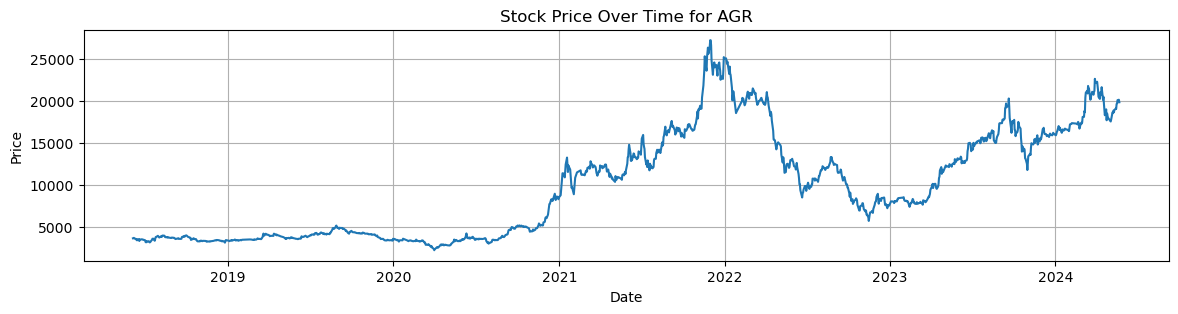

In [119]:
subsquence_plot_price(AGR_df, group_name_0)

Dựa vào biểu đồ trực quan, ta có thể thấy:
- Time series có xu hướng (trend), vì mean thay đổi theo thời gian (vi phạm điều kiện #1).
- Phương sai thay đổi theo thời gian: trước năm 2021 phương sai nhỏ, nhưng sau năm 2021 thì phương sai lớn (vi phạm điều kiện #2).

**Summary Statistics**

In [120]:
def summary_statistics_price(df, df_name):
    if len(df) >= 10:
        # Split data into 10 chunks
        chunks = np.array_split(df['Price'], 10)
        
        # Compare means and variances
        print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
        print("-" * 35)
        for i, chunk in enumerate(chunks, 1):
            print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunk), np.var(chunk)))
    else:
        print("Not enough data to split into 10 chunks")

In [121]:
summary_statistics_price(AGR_df, group_name_0)

Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | 3476.1	 | 4.8412e+04
 2	 | 3733.1	 | 8.0546e+04
 3	 | 3850.6	 | 3.2726e+05
 4	 | 3553.8	 | 5.5924e+05
 5	 | 9430.1	 | 7.6842e+06
 6	 | 1.6997e+04	 | 1.7443e+07
 7	 | 1.6262e+04	 | 2.4156e+07
 8	 | 8837.7	 | 3.5768e+06
 9	 | 1.3767e+04	 | 9.4157e+06
10	 | 1.7362e+04	 | 5.7454e+06


Dựa vào số liệu thống kê mô tả, ta thấy:
- Mean thay đổi theo thời gian (vi phạm điều kiện #1).
- Variance thay đổi theo thời gian (vi phạm điều kiện #2).

**Histogram Plot**

Nếu histogram gần với phân phối chuẩn thì ta có thể dự đoán mean và variance là không đổi theo thời gian.

In [122]:
def histogram_plot_price(series, df_name):
    plt.figure(figsize=(10, 6))
    plt.hist(series, bins=10, edgecolor='black')
    plt.title(f'Histogram of Prices for {df_name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

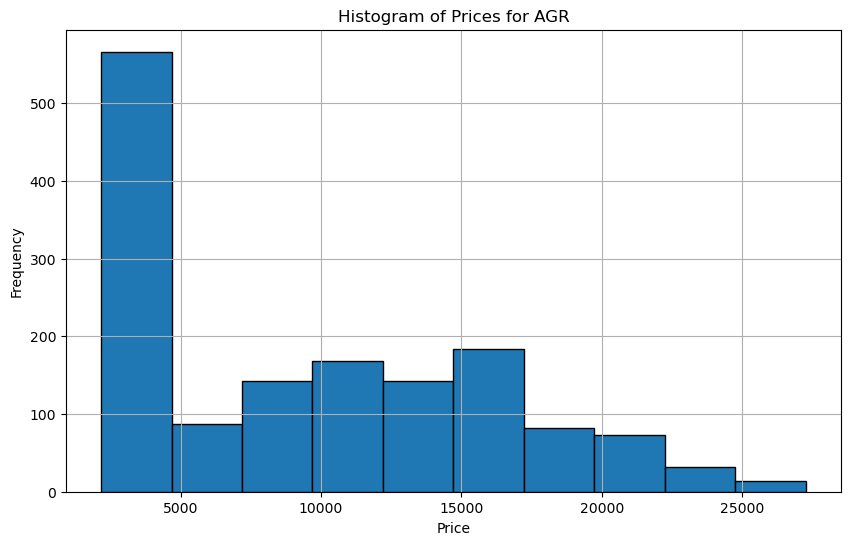

In [123]:
histogram_plot_price(AGR_df['Price'], group_name_0)

Chúng ta có thể sử dụng kiểm định thống kê để kiểm tra:

In [124]:
def normal_test_price(df, df_name):
    k2, p = normaltest(df['Price'])

    print(f"Normality test result for {df_name}:")
    # print(f"Statistic: {k2:.4f}")
    # print(f"P-value: {p:.4f}")

    if p < 0.05:
        print("The null hypothesis of normality is rejected.")
        return False
    else:
        print("The null hypothesis of normality cannot be rejected.")
        return True

In [125]:
normal_test_price(AGR_df, group_name_0)

Normality test result for AGR:
The null hypothesis of normality is rejected.


False

Do đó có thể kết luận được rằng time series trên không tuân theo phân phối chuẩn. Do đó, mean và variance của time series thay đổi theo thời gian (vi phạm điều kiện #1 và #2).

**Augmented Dickey-Fuller (ADF) Test**

- **Null hypothesis** $H_0$: the series is non-stationary.
- **Alternative hypothesis** $H_1$: the series is stationary.
> Chú ý: ADF test có thể không chính xác nếu dataset nhỏ hoặc trong trường hợp phương sai thay đổi (heteroskedasticity). Do đó cần kết hợp nhiều phương pháp bên cạnh ADF test.

In [126]:
def adf_test_price(df, df_name):
    adf_result = adfuller(df['Price'])

    adf, pvalue, usedlag, nobs, critical_values, icbest = adf_result

    print(f"ADF test result for {df_name}:")
    # print("ADF Statistic:", adf)
    # print("p-value:", pvalue)
    # print("Used lag:", usedlag)
    # print("Number of observations:", nobs)
    # print("Critical values:", critical_values)
    # print("IC best:", icbest)

    if pvalue < 0.05:
        print("The null hypothesis of non-stationarity is rejected.")
        return False
    else:
        print("The null hypothesis of non-stationarity cannot be rejected.")
        return True

In [127]:
adf_test_price(AGR_df, group_name_0)

ADF test result for AGR:
The null hypothesis of non-stationarity cannot be rejected.


True

Kết quả của ADF test cho thấy ta không thể bác bỏ $H_0$, do đó time series là non-stationary.

**Vậy, time series về giá cổ phiếu `price` của ngân hàng AGRIBANK là non-stationary.**

#### **1.2. Đánh giá tổng quan tất cả các ngân hàng**

**Sub-sequence plots**

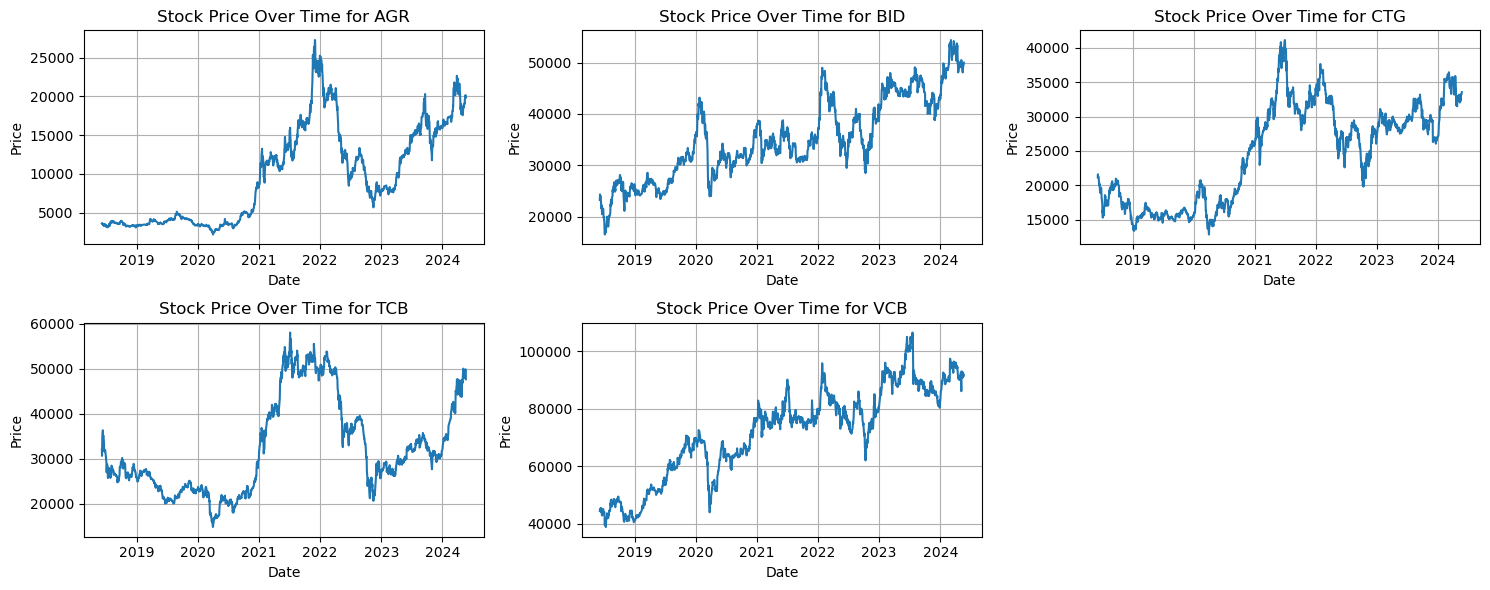

In [128]:
num_plots = len(dataframes)
cols = 3
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, (name, df) in enumerate(dataframes.items(), 1):
    plt.subplot(rows, cols, i)
    plt.plot(df['Date'], df['Price'])
    plt.title(f'Stock Price Over Time for {name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)

plt.tight_layout()  
plt.show()

**Histogram plots**

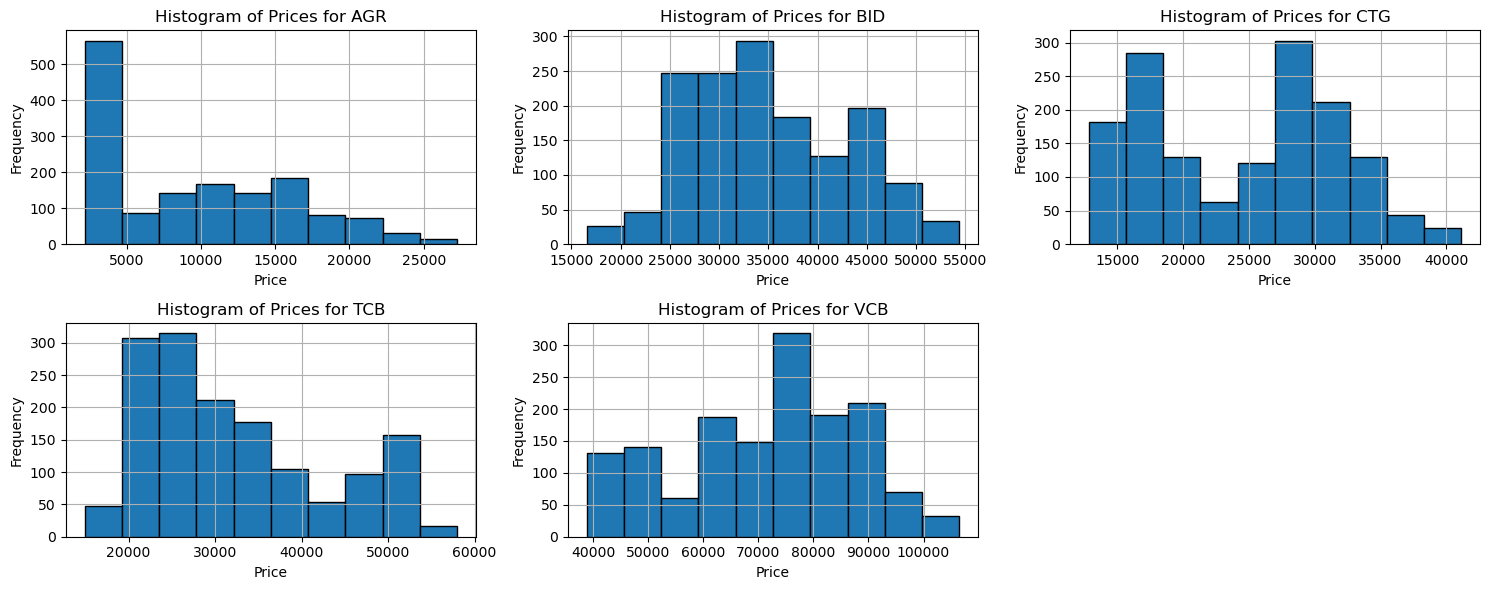

In [129]:
num_plots = len(dataframes)
cols = 3  
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, (name, df) in enumerate(dataframes.items(), 1):
    plt.subplot(rows, cols, i)
    plt.hist(df['Price'], bins=10, edgecolor='black')
    plt.title(f'Histogram of Prices for {name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()  
plt.show()

In [130]:
results = []

for df_name, df in dataframes.items():
    print('\n')
    normal_result = normal_test_price(df, df_name)
    adf_result = adf_test_price(df, df_name)
    results.append([df_name, normal_result, adf_result])



Normality test result for AGR:
The null hypothesis of normality is rejected.
ADF test result for AGR:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for BID:
The null hypothesis of normality is rejected.
ADF test result for BID:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for CTG:
The null hypothesis of normality is rejected.
ADF test result for CTG:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for TCB:
The null hypothesis of normality is rejected.
ADF test result for TCB:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for VCB:
The null hypothesis of normality is rejected.
ADF test result for VCB:
The null hypothesis of non-stationarity cannot be rejected.


In [131]:
results_df = pd.DataFrame(results, columns=['price series', 'normal', 'non-stationary'])
results_df

,price series,normal,non-stationary
0,AGR,False,True
1,BID,False,True
2,CTG,False,True
3,TCB,False,True
4,VCB,False,True


## **2. Prediction**

Ở đây ta sẽ dự đoán giá cổ phiếu cho ngân hàng BIDV (mã BID).

In [132]:
BID_name = 'BID'
BID_df = dataframes[BID_name]
BID_df.tail(5)

,Date,Price,Open,High,Low,Vol.,Change %,XSTC
2975,2024-05-15,48600.0,49000.0,49000.0,48100.0,1390000.0,1.04,BID
2976,2024-05-16,48840.0,49200.0,50300.0,48600.0,2100000.0,0.49,BID
2977,2024-05-17,49350.0,49750.0,50000.0,49200.0,1520000.0,1.04,BID
2978,2024-05-20,49600.0,49450.0,50700.0,49400.0,2190000.0,0.51,BID
2979,2024-05-21,50000.0,49600.0,50300.0,49600.0,493100.0,0.81,BID


Để áp dụng các mô hình ARMA cho mục đích dự đoán, ta cần phải đưa time series từ `non-stationary` về `stationary`. Một số các phương pháp đó là:

| Transformation       | Effect                 |
|----------------------|------------------------|
| Subtract trend       | Constant mean          |
| Apply log            | Constant variance      |
| Differencing         | Remove autocorrelation |
| Seasonal differencing| Remove periodic component|


In [143]:
# Assuming 'df' is your DataFrame with columns 'Date' and 'Price'

# Set index as date
df.set_index('Date', inplace=True)

# Extract 'Price' column as a separate DataFrame
price_df = df[['Price']]

# Print the price DataFrame
print(price_df)


              Price
Date               
2018-06-05  44429.0
2018-06-06  44808.0
2018-06-07  44505.0
2018-06-08  45263.0
2018-06-11  44732.0
...             ...
2024-05-15  91000.0
2024-05-16  92600.0
2024-05-17  91800.0
2024-05-20  91900.0
2024-05-21  91500.0

[1490 rows x 1 columns]


In [186]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue', label='Data')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid(True)
        plt.show()


ADF Statistic: -1.61
p-value: 0.479
Critical Values: ['1%: -3.43', '5%: -2.86', '10%: -2.57']



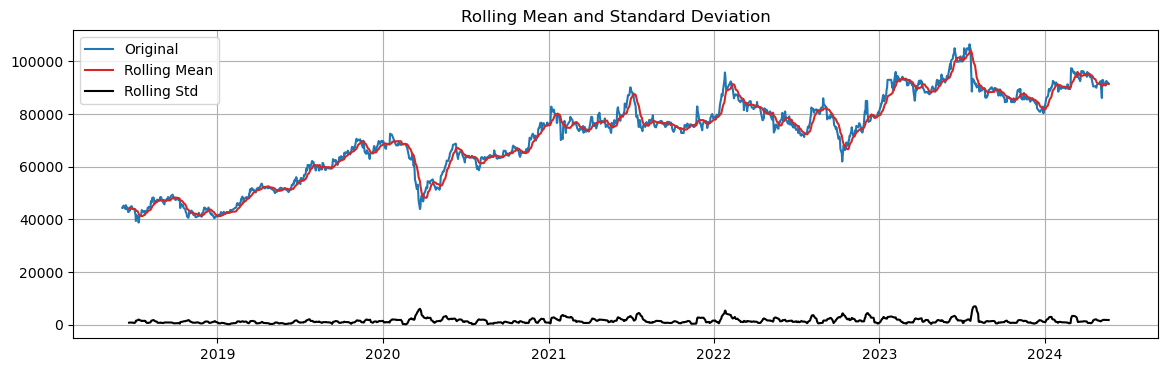

In [146]:
# run ADF on monthly temperatures
adftest(price_df.Price)

In [169]:
# run ADF on annual means
adftest(price_df.Price, plots=False) # no point in plotting the rolling mean/std here

ADF Statistic: -1.61
p-value: 0.479
Critical Values: ['1%: -3.43', '5%: -2.86', '10%: -2.57']



In [188]:
# Perform log transformation
price_log = np.log(price_df.Price)

# Perform first-order differencing
price_log_diff = price_log.diff()

# Print the log-transformed and differenced DataFrame
print(price_log_diff)

Date
2018-06-05         NaN
2018-06-06    0.008494
2018-06-07   -0.006785
2018-06-08    0.016888
2018-06-11   -0.011801
                ...   
2024-05-15    0.002310
2024-05-16    0.017430
2024-05-17   -0.008677
2024-05-20    0.001089
2024-05-21   -0.004362
Name: Price, Length: 1490, dtype: float64


In [189]:
# Perform first-order differencing
price_df['Diff'] = price_log_diff

In [190]:
price_df

,Price,Diff
Date,,
2018-06-05,44429.0,NaN
2018-06-06,44808.0,0.008494
2018-06-07,44505.0,-0.006785
2018-06-08,45263.0,0.016888
2018-06-11,44732.0,-0.011801
...,...,...
2024-05-15,91000.0,0.002310
2024-05-16,92600.0,0.017430
2024-05-17,91800.0,-0.008677


ADF Statistic: -17.14
p-value: 0.000
Critical Values: ['1%: -3.43', '5%: -2.86', '10%: -2.57']



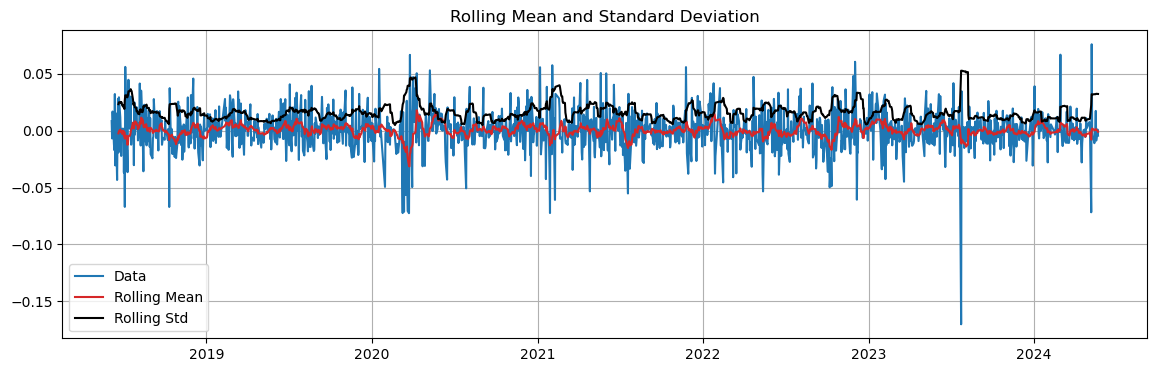

In [191]:
# run ADF on annual means
adftest(price_df.Diff.dropna(), plots=True) # no point in plotting the rolling mean/std here

In [134]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
import pmdarima as pm
np.random.seed(0)   

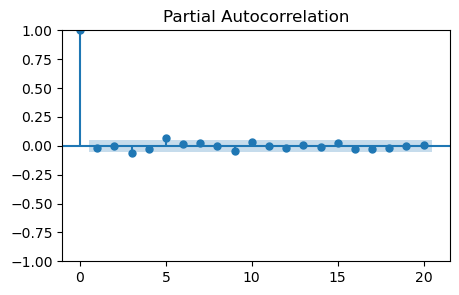

In [192]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(price_df.Diff.dropna(), lags=20, ax=ax); 

Choose AR(3)

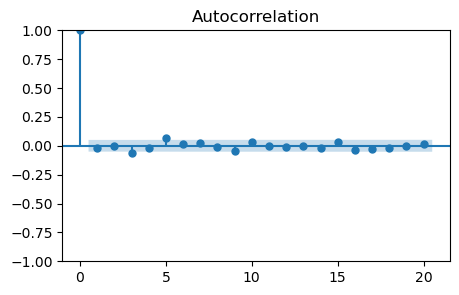

In [193]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(price_df.Diff.dropna(), lags=20, ax=ax); 

Choose MA(3)

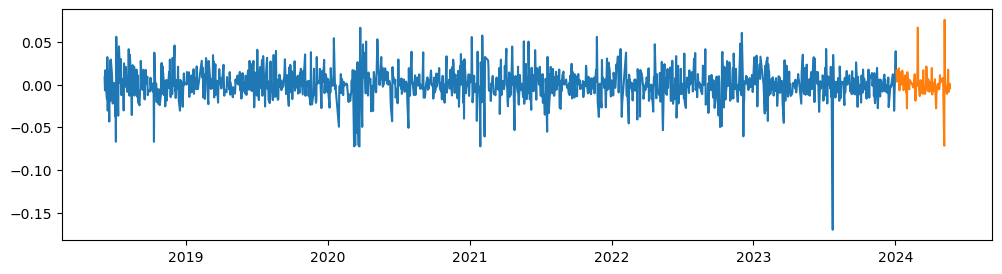

In [194]:
train = price_df.Diff[:-90]
test = price_df.Diff[-90:]

plt.figure(figsize=(12,3))
plt.plot(train)
plt.plot(test);

In [195]:
model = ARIMA(train, order=(3, 0, 3))  # ARIMA with d=0 is equivalent to ARMA
fit_model = model.fit()

print(fit_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   Diff   No. Observations:                 1400
Model:                 ARIMA(3, 0, 3)   Log Likelihood                3656.072
Date:                Tue, 28 May 2024   AIC                          -7296.143
Time:                        13:56:23   BIC                          -7254.189
Sample:                             0   HQIC                         -7280.460
                               - 1400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.852      0.394      -0.001       0.001
ar.L1          0.2998      0.346      0.867      0.386      -0.378       0.977
ar.L2         -0.3583      0.334     -1.072      0.2

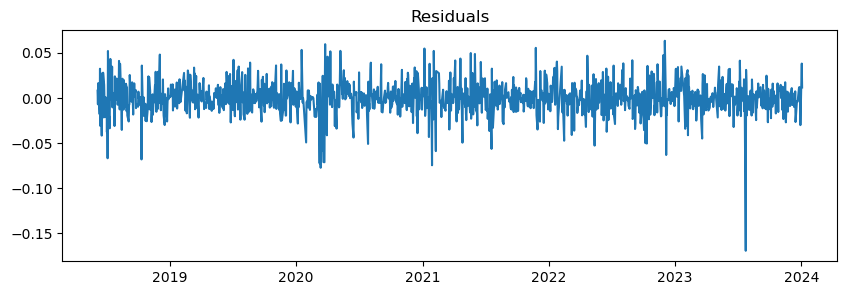

In [196]:
residuals = fit_model.resid

plt.figure(figsize=(10,3))
plt.plot(residuals)
plt.title("Residuals");

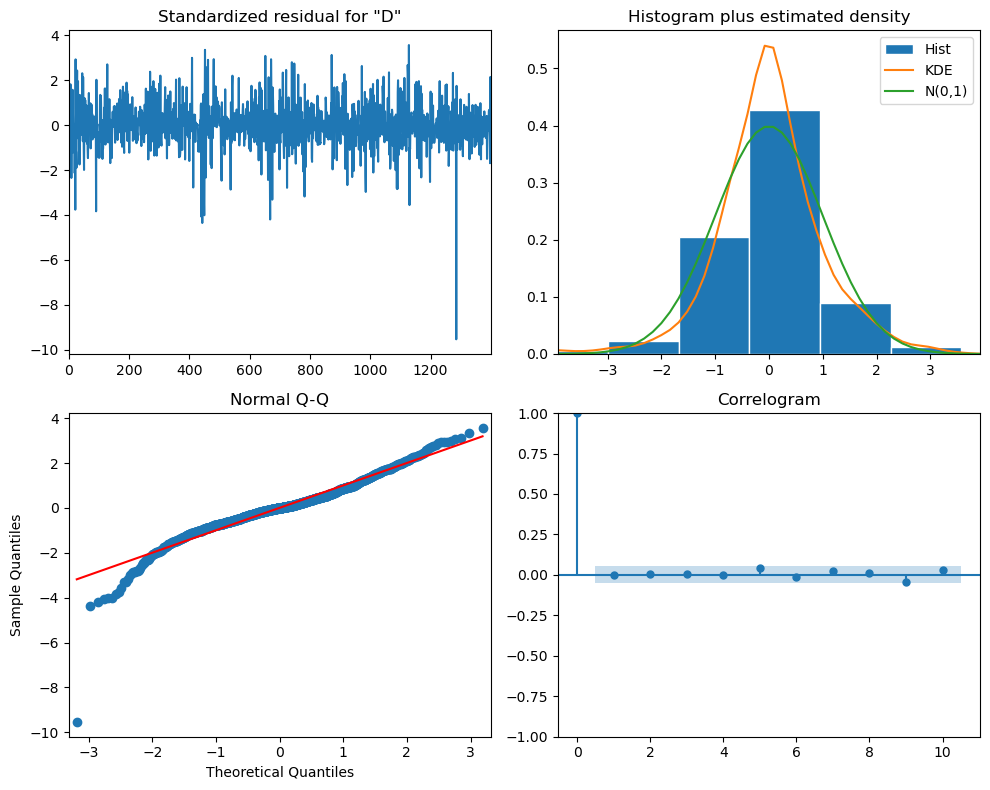

In [197]:
fit_model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout();

Autocorrelation: Ljung-Box test

H0: the residuals are independently distributed (no autocorrelation).

In [198]:
statistic, pval = fit_model.test_serial_correlation(method='ljungbox', lags=10)[0]
print(f'Ljung-Box p-value: {pval.mean():.3f}') 

Ljung-Box p-value: 0.824


Autocorrelation: Durbin Watson test

> The Durbin-Watson statistic typically ranges between 0 and 4. A value close to 2 suggests no autocorrelation. Values significantly different from 2 indicate the presence of autocorrelation. If the Durbin-Watson statistic is close to 0, it indicates positive autocorrelation, while a value close to 4 indicates negative autocorrelation.

In [199]:
durbin_watson = ss.stats.stattools.durbin_watson(fit_model.filter_results.standardized_forecasts_error[0, fit_model.loglikelihood_burn:])
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Durbin-Watson: d=2.00


Heteroskedasticity test

> Heteroskedasticity refers to the situation where the variance of the errors (or residuals) in a regression model is not constant across observations. One commonly used test for heteroskedasticity is the Breusch-Pagan test.

H0: : no heteroskedasticity.

In [200]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='increasing')[0]
print(f'H_a: Increasing - pvalue:{pval:.3f}')

H_a: Increasing - pvalue:0.612


Cannot reject that 

In [201]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='decreasing')[0]
print(f'H_a: Decreasing - pvalue:{pval:.3f}')

H_a: Decreasing - pvalue:0.388


In [202]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='two-sided')[0]
print(f'H_a: Two-sided - pvalue:{pval:.3f}')

H_a: Two-sided - pvalue:0.777


Based on the p-values obtained for all three alternative hypotheses, there is no significant evidence to suggest heteroskedasticity in the model residuals.

We can use both the seasonal_decompose and the STL methods.

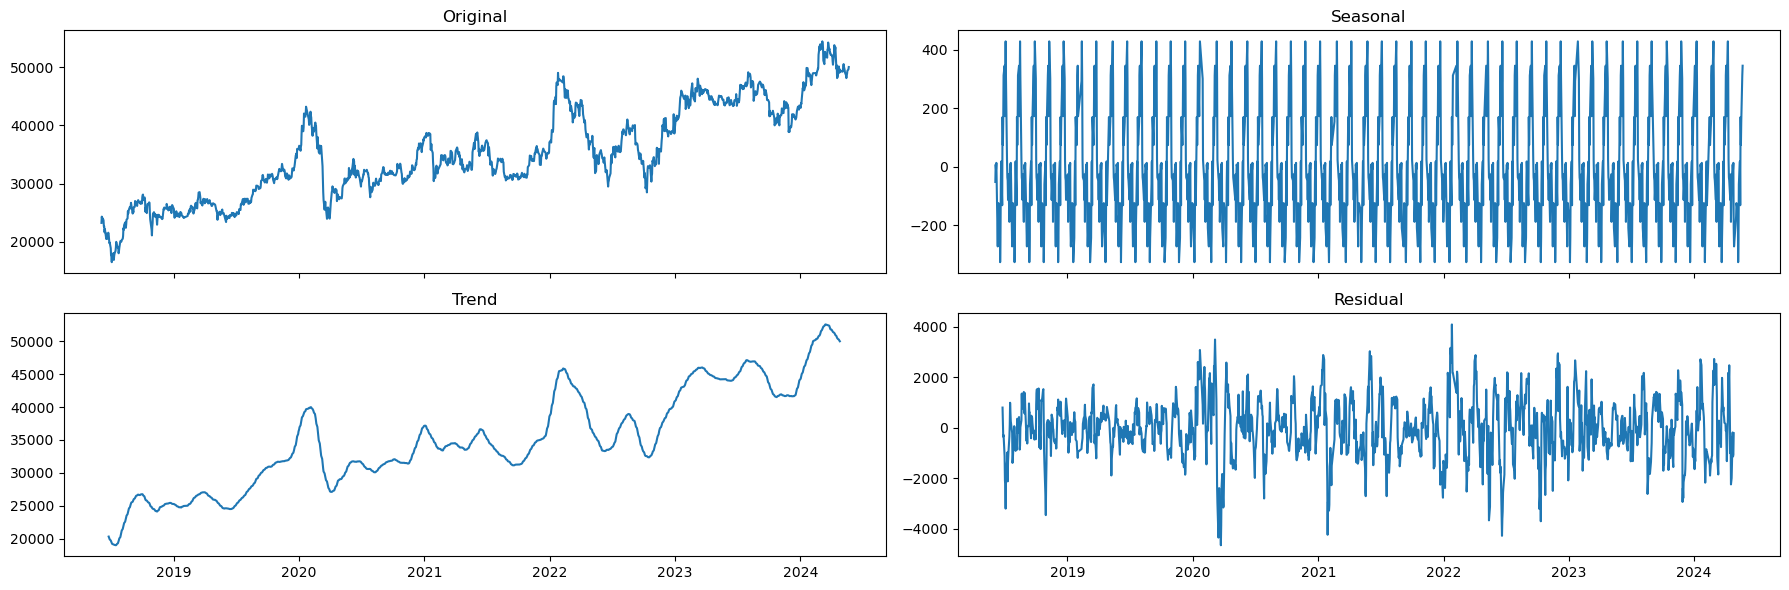

In [ ]:
decomposition = seasonal_decompose(x=BID_price, model='additive', period=30)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(BID_price)
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

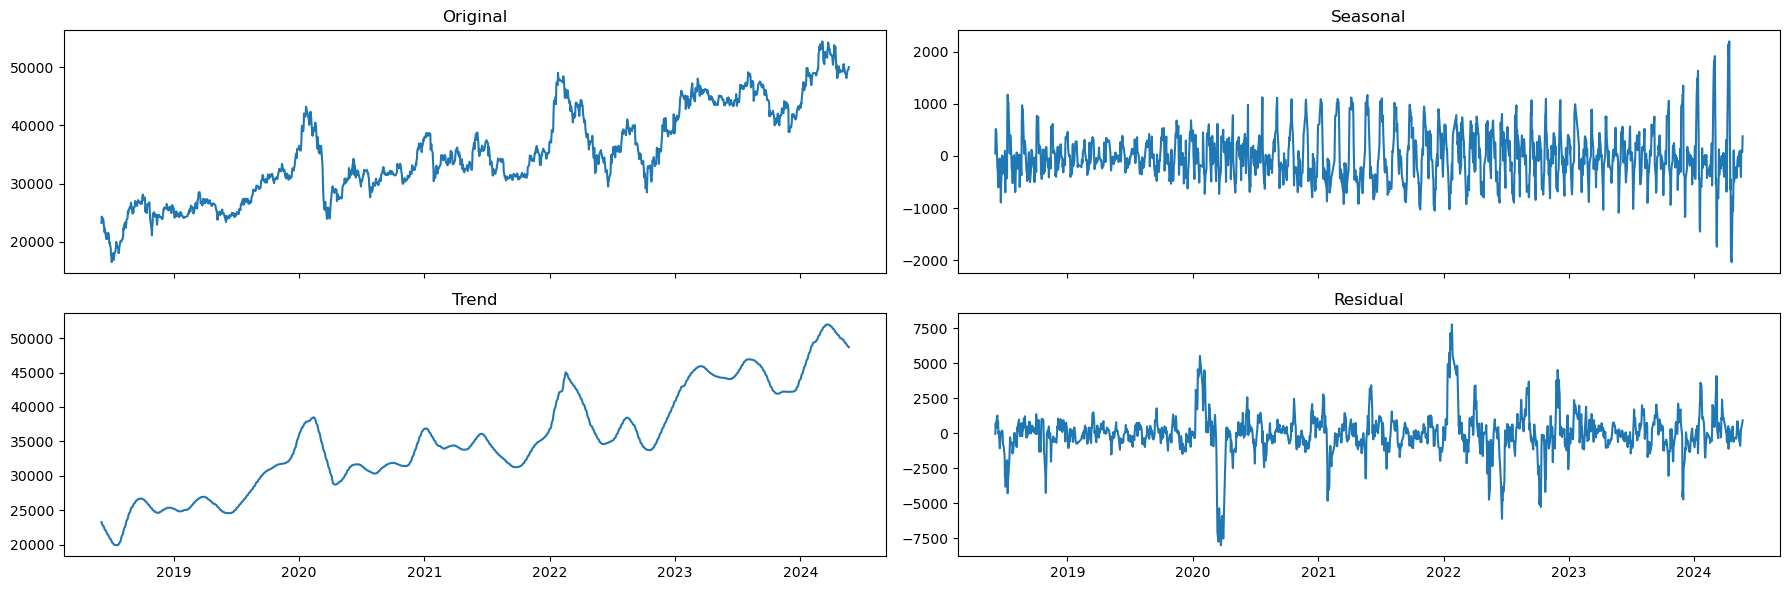

In [ ]:
decomposition = STL(endog=BID_price, period=30, seasonal=13, robust=True).fit()
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(BID_price)
axs[0,0].set_title('Original')
axs[0,1].plot(seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(resid)
axs[1,1].set_title('Residual')
plt.tight_layout()

## ARMA modeling stages

#### Model identification

In [ ]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid(); 

ADF Statistic: -1.58
p-value: 0.493
Critical Values: ['1%: -3.43', '5%: -2.86', '10%: -2.57']



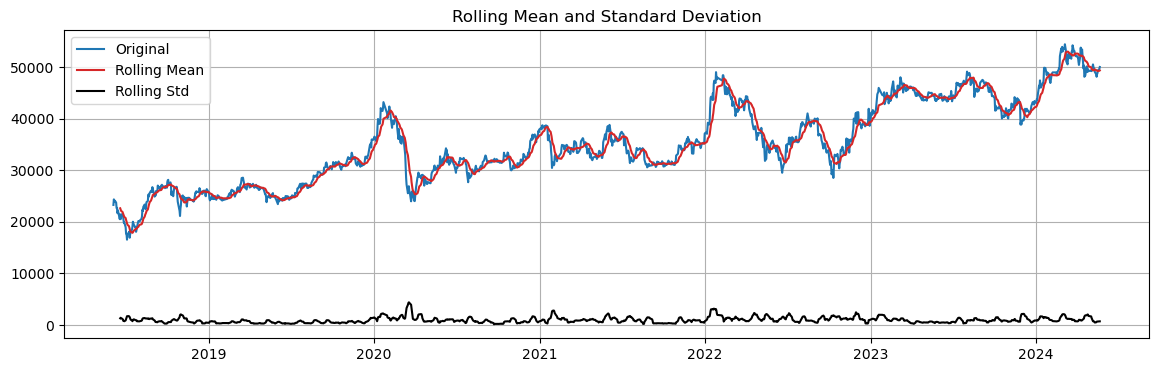

In [ ]:
adftest(BID_price)

Constant variance but changing mean (trend)

Determine seasonality

In [ ]:
adftest(BID_price, plots = False)

ADF Statistic: -1.58
p-value: 0.493
Critical Values: ['1%: -3.43', '5%: -2.86', '10%: -2.57']



In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np

# Perform FFT on the price data
price_series = BID_price.values
n = len(price_series)
price_fft = fft(price_series)
freqs = fftfreq(n)

# Only take the positive half of the frequencies
pos_freqs = freqs[:n // 2]
pos_price_fft = np.abs(price_fft)[:n // 2]

# Find the dominant frequency
dominant_freq = pos_freqs[np.argmax(pos_price_fft[1:]) + 1]  # Ignoring the zero frequency

# Calculate the period
dominant_period = 1 / dominant_freq

print(f'Dominant Frequency: {dominant_freq}')
print(f'Dominant Period: {dominant_period} days')

Dominant Frequency: 0.0006711409395973154
Dominant Period: 1490.0 days


## 1st order differencing

In [ ]:
model = ARIMA(train, order=(3, 0, 3))  # ARIMA with d=0 is equivalent to ARMA
fit_model = model.fit()

print(fit_model.summary())

## Identifying order

In [ ]:
# !conda install -c saravji pmdarima
import pmdarima as pm

In [ ]:
BID_price

Date
2018-06-05    23266.4
2018-06-06    24337.9
2018-06-07    23878.7
2018-06-08    24108.3
2018-06-11    23725.6
               ...   
2024-05-15    48600.0
2024-05-16    48840.0
2024-05-17    49350.0
2024-05-20    49600.0
2024-05-21    50000.0
Name: Price, Length: 1490, dtype: float64

In [ ]:
# Split the data into train and test sets
train, test = BID_price[:1400], BID_price[1400:]

# Use auto_arima to find the best ARIMA model
model_list = pm.auto_arima(train, 
                      start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=2, max_q=2, # Maximum p and q
                      m=12,             # Seasonality
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2, # Maximum p and q
                      seasonal=True,    # Seasonal ARIMA
                      d=None,           # Let model determine 'd'
                      D=1,              # Seasonal difference
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise search to find the best model

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=25774.848, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=23136.636, Time=4.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=24572.429, Time=4.54 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=25778.934, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=23523.438, Time=0.62 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=23005.754, Time=5.93 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=12.24 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.92 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=25770.971, Time=1.25 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=23004.189, Time=9.07 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=23134.003, Time=4.34 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=15.28 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.01 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=12.45 sec
 ARIMA(1,0,1)(2,1,0)[12] interce

In [ ]:
n_periods = 60  # Number of periods to forecast
best_model_fitted, best_model_confint = model_list.predict(n_periods=n_periods, return_conf_int=True)

In [ ]:
def construct_series(fitted, confint, index_of_fc):
    # Construct a series of forecasted values with the corresponding dates
    fitted_series = pd.Series(fitted, index=index_of_fc)

    # Construct a series of lower confidence interval bounds with the corresponding dates
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)

    # Construct a series of upper confidence interval bounds with the corresponding dates
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    
    return fitted_series, lower_series, upper_series


In [ ]:
# Generate a date range for the forecasted periods
index_of_fc = pd.date_range(data.index[-1], periods=n_periods, freq='MS')

best_fitted_series, best_lower_series, best_upper_series = construct_series(best_model_fitted, best_model_confint, index_of_fc)

In [ ]:
len(test)

90

In [ ]:
BID_df['Forecast'] = model_list.predict(n_periods=len(test)) 
BID_df.tail(5)

,Price,Open,High,Low,Vol.,Change %,XSTC,forecast,Forecast
Date,,,,,,,,,
2024-05-15,48600.0,49000.0,49000.0,48100.0,1390000.0,1.04,BID,NaN,NaN
2024-05-16,48840.0,49200.0,50300.0,48600.0,2100000.0,0.49,BID,NaN,NaN
2024-05-17,49350.0,49750.0,50000.0,49200.0,1520000.0,1.04,BID,NaN,NaN
2024-05-20,49600.0,49450.0,50700.0,49400.0,2190000.0,0.51,BID,NaN,NaN
2024-05-21,50000.0,49600.0,50300.0,49600.0,493100.0,0.81,BID,NaN,NaN


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1400
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood              -11496.268
Date:                            Tue, 28 May 2024   AIC                          23002.536
Time:                                    11:10:46   BIC                          23028.714
Sample:                                         0   HQIC                         23012.326
                                           - 1400                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9820      0.022     44.390      0.000       0.939       1.025
ar.L2         -0.0498      0.020   

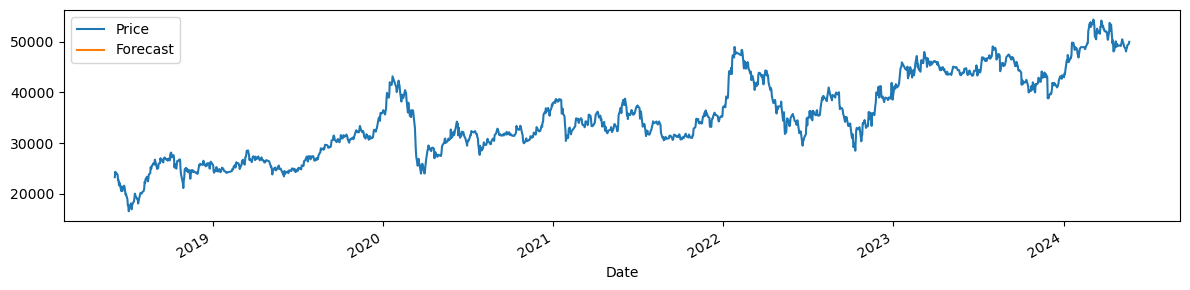

**Subtract estimated trend và seasonality**

In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np

# Perform FFT on the price data
price_series = df['Price'].values
n = len(price_series)
price_fft = fft(price_series)
freqs = fftfreq(n)

# Only take the positive half of the frequencies
pos_freqs = freqs[:n // 2]
pos_price_fft = np.abs(price_fft)[:n // 2]

# Find the dominant frequency
dominant_freq = pos_freqs[np.argmax(pos_price_fft[1:]) + 1]  # Ignoring the zero frequency

# Calculate the period
dominant_period = 1 / dominant_freq

print(f'Dominant Frequency: {dominant_freq}')
print(f'Dominant Period: {dominant_period} days')

Dominant Frequency: 0.0006711409395973154
Dominant Period: 1490.0 days


In [ ]:
def subsequence_plot_price(date_series, price_series, title):
    plt.figure(figsize=(12, 3))
    plt.plot(date_series, price_series)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Log-transformed Price')
    plt.grid(True)
    plt.show()

In [ ]:
# Ensure the 'Date' column is in datetime format
BID_df['Date'] = pd.to_datetime(BID_df['Date'])


In [ ]:
# Original series
price_series = BID_df['Price']

# Remove trend (first-order differencing) from the original series
first_order_diff = price_series.diff().dropna()

# Plot the time series after first-order differencing
time_values_first_order_diff = BID_df['Date'][1:]
time_values_first_order_diff = time_values_first_order_diff[:len(first_order_diff)]
subsequence_plot_price(time_values_first_order_diff, first_order_diff, title="1st Order Differencing from Original Series")

KeyError: 'Date'

In [ ]:
def normal_test_price(series, df_name):
    k2, p = normaltest(series)

    print(f"Normality test result for {df_name}:")
    # print(f"Statistic: {k2:.4f}")
    # print(f"P-value: {p:.4f}")

    if p < 0.05:
        print("The null hypothesis of normality is rejected.")
        return False
    else:
        print("The null hypothesis of normality cannot be rejected.")
        return True

In [ ]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid(); 

Normality test result for seasonal differenced series:
The null hypothesis of normality is rejected.
ADF Statistic: -2.62
p-value: 0.090
Critical Values: ['1%: -3.44', '5%: -2.87', '10%: -2.57']



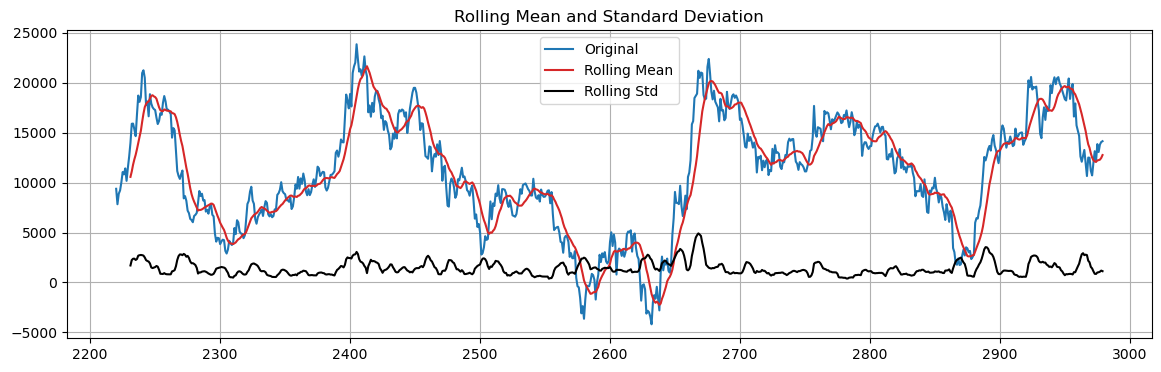

In [ ]:
normal_result = normal_test_price(seasonal_diff, 'seasonal differenced series')
adf_result = adftest(seasonal_diff, plots=True)

ADF Statistic: -40.35
p-value: 0.000
Critical Values: ['1%: -3.43', '5%: -2.86', '10%: -2.57']



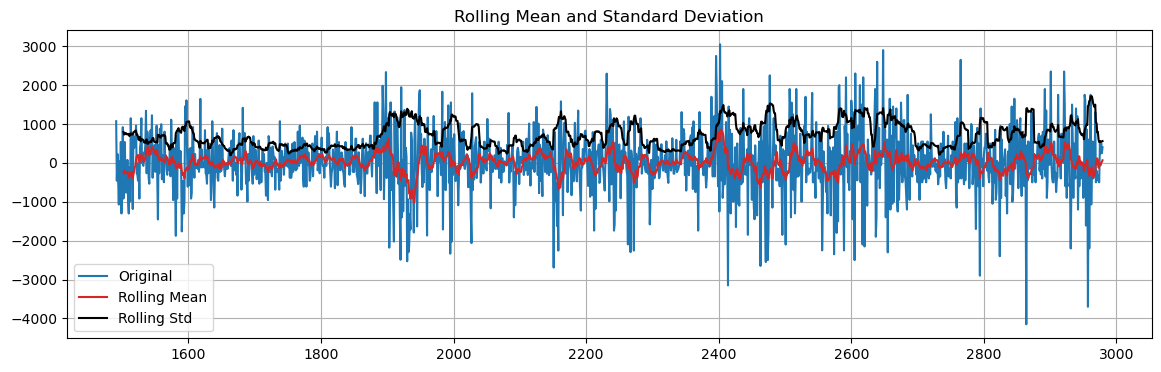

In [ ]:
adf_result = adftest(first_order_diff, plots=True)

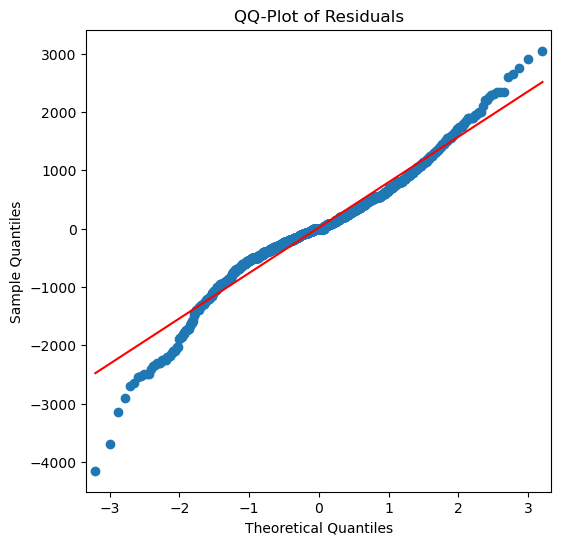

In [ ]:
from statsmodels.graphics.gofplots import qqplot

# QQ-Plot
_, ax = plt.subplots(1, 1, figsize=(6, 6))
qqplot(first_order_diff, line='s', ax=ax)
plt.title('QQ-Plot of Residuals')
plt.show()

In [ ]:
fit_model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout();

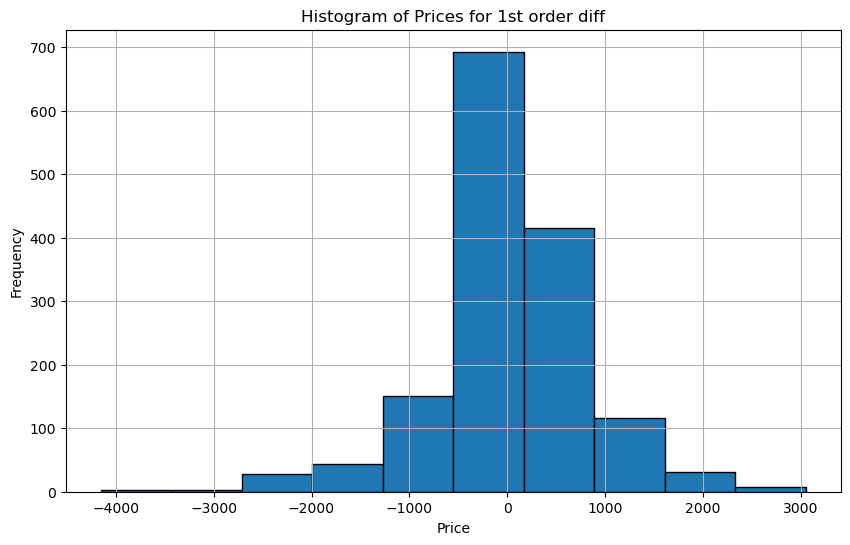

In [ ]:
histogram_plot_price(first_order_diff, '1st order diff')

In [ ]:
normal_result = normal_test_price(first_order_diff, 'seasonal differenced series + 1st order')
adf_result = adf_test_price(first_order_diff, 'seasonal differenced series + 1st order')

Normality test result for seasonal differenced series + 1st order:
The null hypothesis of normality is rejected.
ADF test result for seasonal differenced series + 1st order:
The null hypothesis of non-stationarity is rejected.


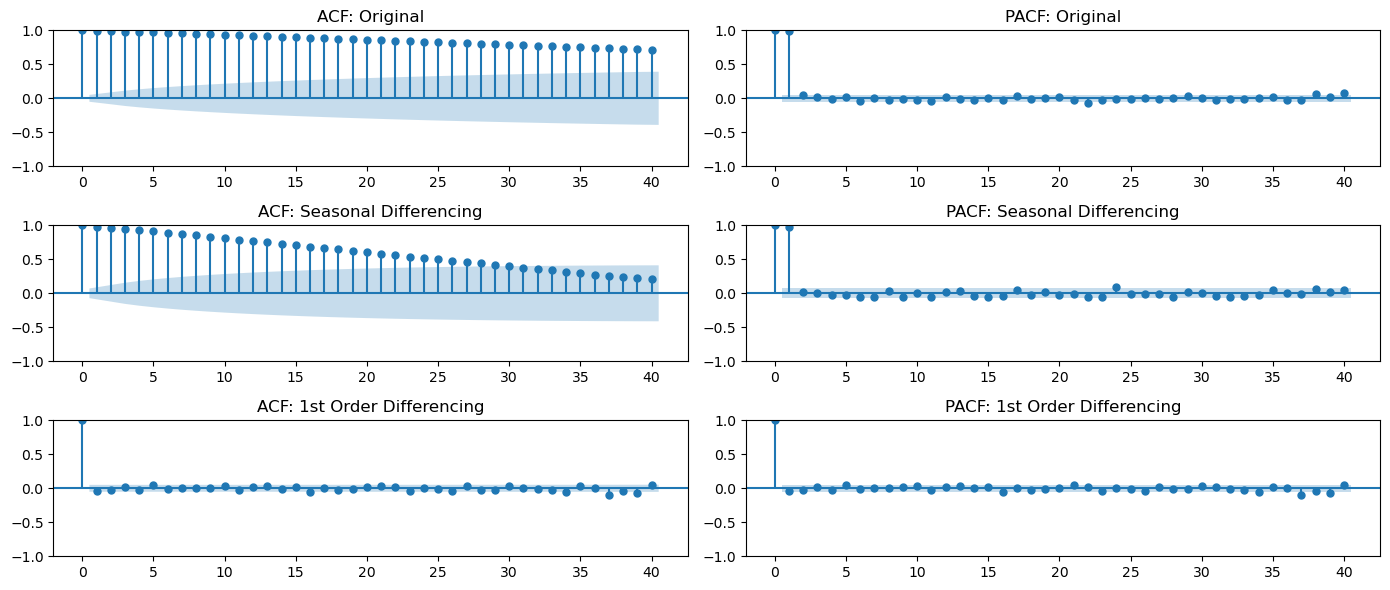

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for seasonally + first-order differenced data
plt.figure(figsize=(14, 6))

plt.subplot(321)
plot_acf(price_series, lags=40, ax=plt.gca())
plt.title('ACF: Original')

plt.subplot(322)
plot_pacf(price_series, lags=40, ax=plt.gca())
plt.title('PACF: Original')

plt.subplot(323)
plot_acf(seasonal_diff, lags=40, ax=plt.gca())
plt.title('ACF: Seasonal Differencing')

plt.subplot(324)
plot_pacf(seasonal_diff, lags=40, ax=plt.gca())
plt.title('PACF: Seasonal Differencing')

plt.subplot(325)
plot_acf(first_order_diff, lags=40, ax=plt.gca())
plt.title('ACF: 1st Order Differencing')

plt.subplot(326)
plot_pacf(first_order_diff, lags=40, ax=plt.gca())
plt.title('PACF: 1st Order Differencing')

plt.tight_layout()
plt.show()

ACF has one spike, rest are essentially zero, so we use MA model, order identified by where plot becomes zero.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF test
result = adfuller(BID_df['Price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.5807536935401865
p-value: 0.49325393774771326


In [ ]:
BID_df['Price_diff'] = BID_df['Price'].diff().dropna()

# ADF test on differenced data
result_diff = adfuller(BID_df['Price_diff'].dropna())
print(f'ADF Statistic (differenced): {result_diff[0]}')
print(f'p-value (differenced): {result_diff[1]}')


ADF Statistic (differenced): -40.3541924490272
p-value (differenced): 0.0


In [ ]:
import itertools
import statsmodels.api as sm

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Search for the best ARIMA model parameters
best_aic = float("inf")
best_pdq = None

for param in pdq:
    try:
        model = sm.tsa.ARIMA(df['Price'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

print(f'Best ARIMA parameters: {best_pdq} with AIC: {best_aic}')


Best ARIMA parameters: (0, 1, 0) with AIC: 25570.543390346844


Best ARIMA parameters: (2, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1192
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9602.948
Date:                Tue, 28 May 2024   AIC                          19215.896
Time:                        12:13:36   BIC                          19241.309
Sample:                             0   HQIC                         19225.472
                               - 1192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6363      0.005   -318.587      0.000      -1.646      -1.626
ar.L2         -0.9915      0.005   -193.455      0.000      -1.002      -0.981
ma.L1          1.65

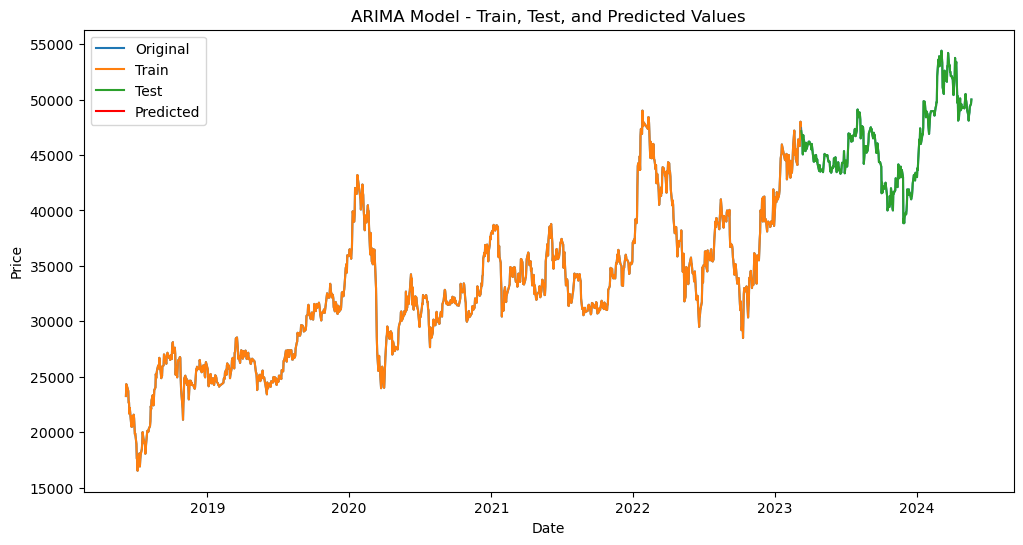

In [ ]:
# Split the data into train and test sets
train_size = int(len(BID_df) * 0.8)  # 80% for training, 20% for testing
train, test = BID_df.iloc[:train_size], BID_df.iloc[train_size:]

# Find the best ARIMA parameters (p, d, q)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None

for param in pdq:
    try:
        model = sm.tsa.ARIMA(train['Price'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except:
        continue

print('Best ARIMA parameters:', best_pdq)

# Fit the ARIMA model with the best parameters on the training data
model = sm.tsa.ARIMA(train['Price'], order=best_pdq)
results = model.fit()
print(results.summary())

# Make predictions for the test data
predictions = results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Construct a DataFrame for the predictions with the correct index
predictions_BID_df = pd.DataFrame(predictions, index=test.index, columns=['Predicted'])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(BID_df['Price'], label='Original')
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(predictions_BID_df['Predicted'], label='Predicted', color='red')
plt.title('ARIMA Model - Train, Test, and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
best_pdq

(2, 1, 2)

In [ ]:
len(predictions)

298

In [ ]:
len(test)

298

In [ ]:
print(test)

              Price     Open     High      Low       Vol.  Change % XSTC  \
Date                                                                       
2023-03-10  47150.0  47450.0  47450.0  46950.0   862200.0     -1.05  BID   
2023-03-13  46250.0  46600.0  46900.0  46250.0   933700.0     -1.91  BID   
2023-03-14  45050.0  46100.0  46350.0  44750.0  1440000.0     -2.59  BID   
2023-03-15  46800.0  46000.0  47400.0  45450.0   628400.0      3.88  BID   
2023-03-16  46250.0  46050.0  46900.0  46050.0   875700.0     -1.18  BID   
...             ...      ...      ...      ...        ...       ...  ...   
2024-05-15  48600.0  49000.0  49000.0  48100.0  1390000.0      1.04  BID   
2024-05-16  48840.0  49200.0  50300.0  48600.0  2100000.0      0.49  BID   
2024-05-17  49350.0  49750.0  50000.0  49200.0  1520000.0      1.04  BID   
2024-05-20  49600.0  49450.0  50700.0  49400.0  2190000.0      0.51  BID   
2024-05-21  50000.0  49600.0  50300.0  49600.0   493100.0      0.81  BID   

           

In [ ]:
type(predictions)

pandas.core.series.Series

In [ ]:
# Construct a DataFrame for the predictions with the correct index
predictions_BID_df = pd.DataFrame(predictions, index=test.index, columns=['Prediction'])

# Add predictions to a new column 'Prediction' of the test DataFrame
test['Prediction'] = predictions_BID_df

# Print the updated test DataFrame
print(test)


              Price     Open     High      Low       Vol.  Change % XSTC  \
Date                                                                       
2023-03-10  47150.0  47450.0  47450.0  46950.0   862200.0     -1.05  BID   
2023-03-13  46250.0  46600.0  46900.0  46250.0   933700.0     -1.91  BID   
2023-03-14  45050.0  46100.0  46350.0  44750.0  1440000.0     -2.59  BID   
2023-03-15  46800.0  46000.0  47400.0  45450.0   628400.0      3.88  BID   
2023-03-16  46250.0  46050.0  46900.0  46050.0   875700.0     -1.18  BID   
...             ...      ...      ...      ...        ...       ...  ...   
2024-05-15  48600.0  49000.0  49000.0  48100.0  1390000.0      1.04  BID   
2024-05-16  48840.0  49200.0  50300.0  48600.0  2100000.0      0.49  BID   
2024-05-17  49350.0  49750.0  50000.0  49200.0  1520000.0      1.04  BID   
2024-05-20  49600.0  49450.0  50700.0  49400.0  2190000.0      0.51  BID   
2024-05-21  50000.0  49600.0  50300.0  49600.0   493100.0      0.81  BID   

           

Best ARIMA parameters: (2, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1192
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9602.948
Date:                Tue, 28 May 2024   AIC                          19215.896
Time:                        13:22:18   BIC                          19241.309
Sample:                             0   HQIC                         19225.472
                               - 1192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6363      0.005   -318.587      0.000      -1.646      -1.626
ar.L2         -0.9915      0.005   -193.455      0.000      -1.002      -0.981
ma.L1          1.65

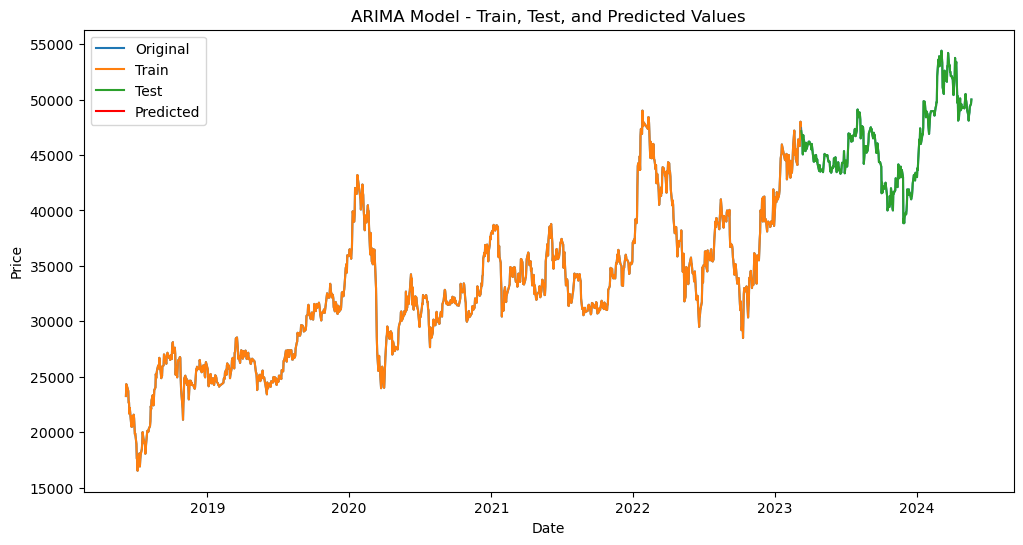

In [ ]:
import pandas as pd
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt

# Assuming BID_df, train, test are defined correctly
# Assuming BID_df has a column 'Price'

# Find the best ARIMA parameters (p, d, q)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None

for param in pdq:
    try:
        model = sm.tsa.ARIMA(train['Price'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
    except Exception as e:
        print("ARIMA fitting error:", e)
        continue

print('Best ARIMA parameters:', best_pdq)

# Fit the ARIMA model with the best parameters on the training data
try:
    model = sm.tsa.ARIMA(train['Price'], order=best_pdq)
    results = model.fit()
    print(results.summary())

    # Make predictions for the test data
    predictions = results.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

    # Construct a DataFrame for the predictions with the correct index
    predictions_BID_df = pd.DataFrame(predictions, index=test.index, columns=['Prediction'])

    # Add predictions to a new column 'Prediction' of the test DataFrame
    test['Prediction'] = predictions

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(BID_df['Price'], label='Original')
    plt.plot(train['Price'], label='Train')
    plt.plot(test['Price'], label='Test')
    plt.plot(predictions_BID_df['Prediction'], label='Predicted', color='red')
    plt.title('ARIMA Model - Train, Test, and Predicted Values')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
except Exception as e:
    print("ARIMA prediction error:", e)


In [ ]:
# Construct a DataFrame for the predictions with the correct index
predictions_BID_df = pd.DataFrame(predictions, index=test.index, columns=['Prediction'])

# Add predictions to a new column 'Prediction' of the test DataFrame
test['Prediction'] = predictions_BID_df['Prediction']

# Print the updated test DataFrame
print(test)


              Price     Open     High      Low       Vol.  Change % XSTC  \
Date                                                                       
2023-03-10  47150.0  47450.0  47450.0  46950.0   862200.0     -1.05  BID   
2023-03-13  46250.0  46600.0  46900.0  46250.0   933700.0     -1.91  BID   
2023-03-14  45050.0  46100.0  46350.0  44750.0  1440000.0     -2.59  BID   
2023-03-15  46800.0  46000.0  47400.0  45450.0   628400.0      3.88  BID   
2023-03-16  46250.0  46050.0  46900.0  46050.0   875700.0     -1.18  BID   
...             ...      ...      ...      ...        ...       ...  ...   
2024-05-15  48600.0  49000.0  49000.0  48100.0  1390000.0      1.04  BID   
2024-05-16  48840.0  49200.0  50300.0  48600.0  2100000.0      0.49  BID   
2024-05-17  49350.0  49750.0  50000.0  49200.0  1520000.0      1.04  BID   
2024-05-20  49600.0  49450.0  50700.0  49400.0  2190000.0      0.51  BID   
2024-05-21  50000.0  49600.0  50300.0  49600.0   493100.0      0.81  BID   

           

In [ ]:
# Print indices for debugging
print("Test index:", test.index)
print("Predictions index:", predictions_BID_df.index)


Test index: DatetimeIndex(['2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21',
               '2023-03-22', '2023-03-23',
               ...
               '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-13',
               '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17',
               '2024-05-20', '2024-05-21'],
              dtype='datetime64[ns]', name='Date', length=298, freq=None)
Predictions index: DatetimeIndex(['2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-20', '2023-03-21',
               '2023-03-22', '2023-03-23',
               ...
               '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-13',
               '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17',
               '2024-05-20', '2024-05-21'],
              dtype='datetime64[ns]', name='Date', length=298, freq=None)


In [ ]:
print("Predictions array:", predictions)


Predictions array: 1192    47406.143601
1193    47631.268957
1194    47504.672166
1195    47488.616740
1196    47640.406802
            ...     
1485    47523.305289
1486    47564.251119
1487    47498.170798
1488    47565.701948
1489    47520.717161
Name: predicted_mean, Length: 298, dtype: float64


In [ ]:
print(predictions)



1192    47406.143601
1193    47631.268957
1194    47504.672166
1195    47488.616740
1196    47640.406802
            ...     
1485    47523.305289
1486    47564.251119
1487    47498.170798
1488    47565.701948
1489    47520.717161
Name: predicted_mean, Length: 298, dtype: float64
              Price     Open     High      Low       Vol.  Change % XSTC  \
Date                                                                       
2023-03-10  47150.0  47450.0  47450.0  46950.0   862200.0     -1.05  BID   
2023-03-13  46250.0  46600.0  46900.0  46250.0   933700.0     -1.91  BID   
2023-03-14  45050.0  46100.0  46350.0  44750.0  1440000.0     -2.59  BID   
2023-03-15  46800.0  46000.0  47400.0  45450.0   628400.0      3.88  BID   
2023-03-16  46250.0  46050.0  46900.0  46050.0   875700.0     -1.18  BID   
...             ...      ...      ...      ...        ...       ...  ...   
2024-05-15  48600.0  49000.0  49000.0  48100.0  1390000.0      1.04  BID   
2024-05-16  48840.0  49200.0  50300

In [ ]:
test

,Price,Open,High,Low,Vol.,Change %,XSTC,forecast,Forecast,Price_diff
Date,,,,,,,,,,
2023-03-10,47150.0,47450.0,47450.0,46950.0,862200.0,-1.05,BID,NaN,NaN,-500.0
2023-03-13,46250.0,46600.0,46900.0,46250.0,933700.0,-1.91,BID,NaN,NaN,-900.0
2023-03-14,45050.0,46100.0,46350.0,44750.0,1440000.0,-2.59,BID,NaN,NaN,-1200.0
2023-03-15,46800.0,46000.0,47400.0,45450.0,628400.0,3.88,BID,NaN,NaN,1750.0
2023-03-16,46250.0,46050.0,46900.0,46050.0,875700.0,-1.18,BID,NaN,NaN,-550.0
...,...,...,...,...,...,...,...,...,...,...
2024-05-15,48600.0,49000.0,49000.0,48100.0,1390000.0,1.04,BID,NaN,NaN,500.0
2024-05-16,48840.0,49200.0,50300.0,48600.0,2100000.0,0.49,BID,NaN,NaN,240.0
2024-05-17,49350.0,49750.0,50000.0,49200.0,1520000.0,1.04,BID,NaN,NaN,510.0
